# Self-supervised-Fake-News-Detection-on-Social-Media

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling, BertForMaskedLM
import openpyxl
from torch import tensor
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

## Sanity Test

E:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


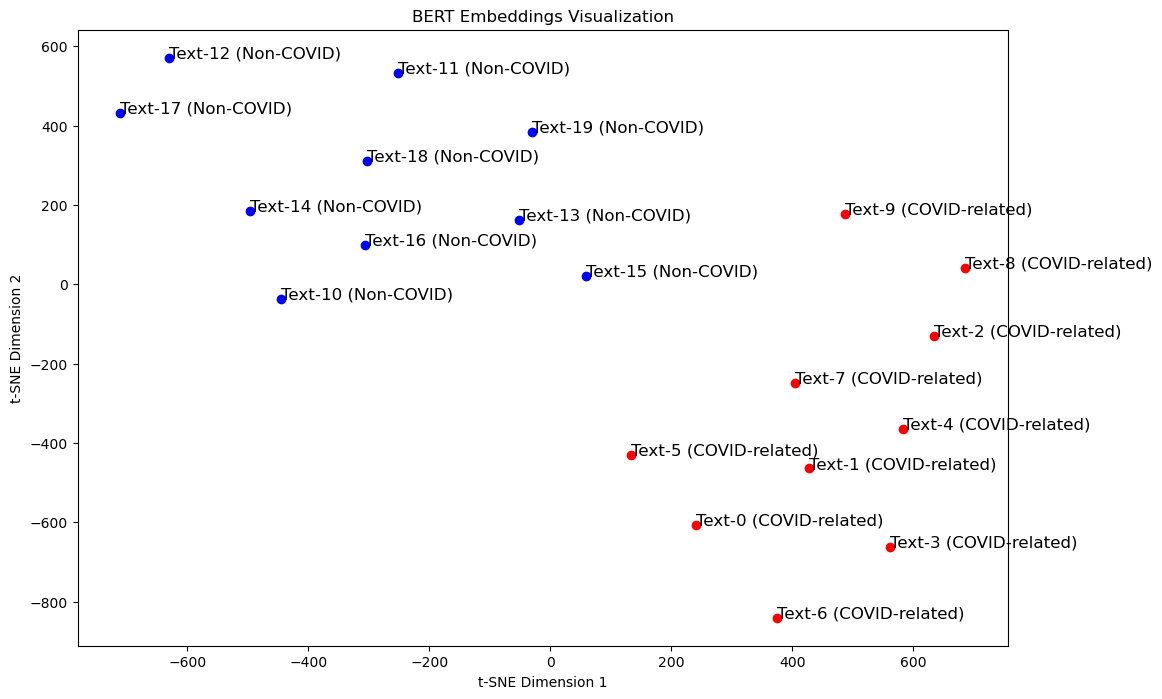

In [2]:
# 初始化 BERT 模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# 定义获取 BERT 嵌入的函数
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())
    return np.array(embeddings)

# 定义一小批示例文本和标签
texts = [
    # COVID-related sentences
    "The COVID-19 vaccine rollout is happening.",
    "COVID cases are spiking in my area.",
    "Due to the pandemic, the event was cancelled.",
    "What are the symptoms of the coronavirus?",
    "People are stockpiling hand sanitizers due to COVID.",
    "COVID-19 has impacted the global economy.",
    "Social distancing is key to stop the spread.",
    "Schools have been closed due to COVID-19.",
    "Many people have lost their jobs due to the pandemic.",
    "Healthcare workers are on the frontline.",

    # Non-COVID-related sentences
    "I like to play video games.",
    "She is going on a vacation to the mountains.",
    "I bought a new pair of shoes.",
    "The book I read was fantastic.",
    "I love Italian food.",
    "The movie was not that great.",
    "I like to listen to classical music.",
    "I bought a new phone.",
    "I love to travel and see new places.",
    "My dog is really cute.",
]

# Labels for these texts
labels = [1]*10 + [0]*10  # First 10 are COVID-related (1), next 10 are not (0)

# 获取 BERT 嵌入
embeddings = get_bert_embeddings(texts)

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, perplexity=10, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# 进行可视化
plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    x, y = embeddings_2d[i]
    if label == 1:
        plt.scatter(x, y, c='r')
        plt.text(x, y, f"Text-{i} (COVID-related)", fontsize=12)
    else:
        plt.scatter(x, y, c='b')
        plt.text(x, y, f"Text-{i} (Non-COVID)", fontsize=12)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('BERT Embeddings Visualization')
plt.show()

## Define functions & Data preprocessing

In [3]:
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www.\S+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    return tweet

#accepts a list of news articles as input
def get_bert_embeddings(news_articles):
    embeddings = []
    for article in news_articles:
        inputs = tokenizer(article, return_tensors="pt", max_length=512, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[0][0].numpy())
    return np.array(embeddings)

df_labeled = pd.read_excel('Constraint_Train.xlsx')
pd.set_option('display.max_colwidth', None)
df_labeled['CleanedTweets'] = df_labeled['tweet'].apply(clean_tweet)
df_labeled = df_labeled.drop(columns=['tweet'])
df_labeled['label'] = df_labeled['label'].replace({'real': 1, 'fake': 0})
df_labeled = df_labeled[['id', 'CleanedTweets', 'label']]

# -------------------------------------------------------------------------
df_unlabeled = pd.read_excel('Constraint_Test.xlsx')
pd.set_option('display.max_colwidth', None)
df_unlabeled['CleanedTweets'] = df_unlabeled['tweet'].apply(clean_tweet)
df_unlabeled = df_unlabeled.drop(columns=['tweet'])
#提取出有用的列表
news_articles = df_unlabeled['CleanedTweets'].tolist()

## Fine-tuning (This part will take a long time to train)

In [3]:
# 从预训练的BERT模型加载标记器和模型
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# 创建用于微调的数据集
class UnlabeledDataset(Dataset):
    def __init__(self, tokenizer, texts, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')

    def __getitem__(self, idx):
        item = {key: tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# 对未标签数据进行编码
unlabeled_dataset = UnlabeledDataset(tokenizer, news_articles)

# 创建训练参数
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    logging_dir='./logs',
)

# 创建Trainer实例
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=unlabeled_dataset,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True),
)

# 开始微调
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'news_articles' is not defined

In [ ]:
# 定义保存路径
save_path = r"C:\Users\59360\Desktop\Prototype with Twitter Datasets\Prototype with Twitter Datasets\my_finetuned_model"

# 保存微调后的模型
trainer.save_model(save_path)

## Extract embeddings

In [4]:
# 加载微调后的模型
model_path = "C:/Users/59360/Desktop/Prototype with Twitter Datasets/Prototype with Twitter Datasets/my_finetuned_model"
fine_tuned_model = BertModel.from_pretrained(model_path)

Some weights of BertModel were not initialized from the model checkpoint at C:/Users/59360/Desktop/Prototype with Twitter Datasets/Prototype with Twitter Datasets/my_finetuned_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 筛选出标签为真（1）的数据
df_real = df_labeled[df_labeled['label'] == 1]

# 筛选出标签为假（0）的数据
df_fake = df_labeled[df_labeled['label'] == 0]

# 从每个子集中随机选择300条数据
df_real_sample = df_real.sample(n=300, random_state=1)
df_fake_sample = df_fake.sample(n=300, random_state=1)

# 合并这两个子集以形成一个包含600条数据的新数据集
df_sample = pd.concat([df_real_sample, df_fake_sample])

# 对样本数据进行打乱
df_sample = df_sample.sample(frac=1, random_state=1).reset_index(drop=True)

# 提取出有用的列表
sample_articles = df_sample['CleanedTweets'].tolist()
sample_labels = df_sample['label'].tolist()

# 移除已经被抽样的600条数据
df_remaining = df_labeled.drop(df_sample.index)

# 重置索引
df_remaining = df_remaining.reset_index(drop=True)

# 提取出剩下的有用的列表
remaining_articles = df_remaining['CleanedTweets'].tolist()
remaining_labels = df_remaining['label'].tolist()

In [6]:
# 这个函数现在接受一个额外的参数：model
def get_bert_embeddings(news_articles, model):
    embeddings = []
    for article in news_articles:
        inputs = tokenizer(article, return_tensors="pt", max_length=512, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[0][0].numpy())
    return np.array(embeddings)

## Neural network

In [7]:
class FakeNewsClassifier(nn.Module):
    def __init__(self, input_dim):
        super(FakeNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Batch Normalization
        self.dropout1 = nn.Dropout(0.5)  # Dropout

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))
        return x

train_embeddings = get_bert_embeddings(sample_articles, fine_tuned_model)
test_embeddings = get_bert_embeddings(remaining_articles, fine_tuned_model)

X_train = torch.tensor(train_embeddings, dtype=torch.float32)
y_train = torch.tensor(sample_labels, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(test_embeddings, dtype=torch.float32)
y_test = torch.tensor(remaining_labels, dtype=torch.float32).unsqueeze(1)

model = FakeNewsClassifier(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)

predicted_labels = (predictions > 0.5).float()
correct = (predicted_labels == y_test).sum().item()
total = y_test.size(0)
accuracy = correct / total

print(f"Neural Network Accuracy on Test Data: {accuracy * 100:.2f}%")

Epoch 0, Loss: 0.7199141979217529
Epoch 10, Loss: 0.22507517039775848
Epoch 20, Loss: 0.10846100002527237
Epoch 30, Loss: 0.043865785002708435
Epoch 40, Loss: 0.022876527160406113
Epoch 50, Loss: 0.013687443919479847
Epoch 60, Loss: 0.009859416633844376
Epoch 70, Loss: 0.007026423700153828
Epoch 80, Loss: 0.0058549540117383
Epoch 90, Loss: 0.0050993021577596664
Neural Network Accuracy on Test Data: 93.14%


## SVM

In [8]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_embeddings, sample_labels)

predicted_labels = svm_classifier.predict(test_embeddings)

accuracy = accuracy_score(remaining_labels, predicted_labels) * 100
print(f"SVM Accuracy: {accuracy:.2f}%")

SVM Accuracy: 91.05%


## Nearest-neighbour and K-means clustering

In [15]:
distance_matrix = euclidean_distances(test_embeddings, train_embeddings)
print(np.amin(distance_matrix, axis=1))
min_values = np.amin(distance_matrix, axis=1)

# 计算平均值
mean_value = np.mean(min_values)
print(f"Average of minimum values: {mean_value}")

# 计算中位数
median_value = np.median(min_values)
print(f"Median of minimum values: {median_value}")
nearest_indices = np.argmin(distance_matrix, axis=1)
predicted_labels = np.array([sample_labels[i] for i in nearest_indices])

accuracy = accuracy_score(remaining_labels, predicted_labels)
print(f"Nearest-neighbor Accuracy: {accuracy:.2f}")

[4.027691  5.514807  5.09495   ... 5.1999326 8.256555  6.0861764]
Average of minimum values: 5.036808013916016
Median of minimum values: 5.557154655456543
Nearest-neighbor Accuracy: 0.89


In [16]:
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(train_embeddings)

cluster_to_label = {}
for i in range(n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_labels = np.array(sample_labels)[cluster_indices]
    majority_label = np.argmax(np.bincount(cluster_labels))
    cluster_to_label[i] = majority_label

predicted_cluster_labels = kmeans.predict(test_embeddings)
predicted_labels = np.array([cluster_to_label[label] for label in predicted_cluster_labels])

accuracy = accuracy_score(remaining_labels, predicted_labels)
print(f"K-means Clustering Accuracy: {accuracy:.2f}")

E:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


K-means Clustering Accuracy: 0.87


In [11]:
# 初始化PCA模型
pca = PCA(n_components=50)  # 降维到50个主成分

# 对600条抽样的数据进行降维
train_embeddings_pca = pca.fit_transform(train_embeddings)

# 对剩余的数据进行降维
test_embeddings_pca = pca.transform(test_embeddings)

In [17]:
distance_matrix = euclidean_distances(test_embeddings_pca, train_embeddings_pca)
print(np.amin(distance_matrix, axis=1))
min_values = np.amin(distance_matrix, axis=1)

# 计算平均值
mean_value = np.mean(min_values)
print(f"Average of minimum values: {mean_value}")

# 计算中位数
median_value = np.median(min_values)
print(f"Median of minimum values: {median_value}")

nearest_indices = np.argmin(distance_matrix, axis=1)
predicted_labels = np.array([sample_labels[i] for i in nearest_indices])

accuracy = accuracy_score(remaining_labels, predicted_labels)
print(f"Nearest-neighbor Accuracy: {accuracy:.2f}")

[2.1156757 3.5628028 3.1216328 ... 3.7191248 5.428786  4.326467 ]
Average of minimum values: 3.399766206741333
Median of minimum values: 3.730079174041748
Nearest-neighbor Accuracy: 0.89


In [18]:
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(train_embeddings_pca)

cluster_to_label = {}
for i in range(n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_labels = np.array(sample_labels)[cluster_indices]
    majority_label = np.argmax(np.bincount(cluster_labels))
    cluster_to_label[i] = majority_label

predicted_cluster_labels = kmeans.predict(test_embeddings_pca)
predicted_labels = np.array([cluster_to_label[label] for label in predicted_cluster_labels])

accuracy = accuracy_score(remaining_labels, predicted_labels)
print(f"K-means Clustering Accuracy: {accuracy:.2f}")

E:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


K-means Clustering Accuracy: 0.88
